In [515]:
import kaggle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from keras.models import *

In [516]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")
submission_df = pd.read_csv("certificatbigdata/sample_submission.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [517]:
train_df

,id,date,customers,open,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,0,a,1,0
1,128,2013-01-01,0,0,0,a,1,0
2,420,2013-01-01,0,0,0,a,1,0
3,225,2013-01-01,0,0,0,a,1,0
4,144,2013-01-01,0,0,0,a,1,0
...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343
813763,796,2015-07-31,769,1,1,0,1,8913
813764,230,2015-07-31,1091,1,1,0,1,10988
813765,387,2015-07-31,1402,1,1,0,1,14533


In [518]:
store_df

,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN
...,...,...,...,...
1110,1111,a,a,"Jan,Apr,Jul,Oct"
1111,1112,c,c,NaN
1112,1113,a,c,NaN
1113,1114,a,c,NaN


# DATA CLEANING

In [519]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [520]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [521]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [522]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [523]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [524]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)
test_df['state_holliday'] = test_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [525]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [526]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [527]:
# Volume de vente est toujours positif
train_df['y'].min()

0

In [528]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [529]:
test_df['y'].min()

0

In [530]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

train_df = train_df.drop(columns=['open'])
test_df = test_df.drop(columns=['open'])

In [531]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [532]:
import seaborn as sns

<AxesSubplot:>

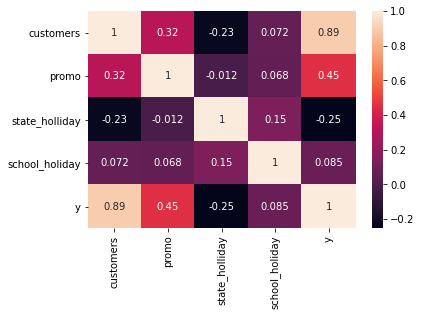

In [533]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

array([[<AxesSubplot:xlabel='customers', ylabel='customers'>,
        <AxesSubplot:xlabel='promo', ylabel='customers'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='customers'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='customers'>,
        <AxesSubplot:xlabel='y', ylabel='customers'>],
       [<AxesSubplot:xlabel='customers', ylabel='promo'>,
        <AxesSubplot:xlabel='promo', ylabel='promo'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='promo'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='promo'>,
        <AxesSubplot:xlabel='y', ylabel='promo'>],
       [<AxesSubplot:xlabel='customers', ylabel='state_holliday'>,
        <AxesSubplot:xlabel='promo', ylabel='state_holliday'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='state_holliday'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='state_holliday'>,
        <AxesSubplot:xlabel='y', ylabel='state_holliday'>],
       [<AxesSubplot:xlabel='customers', ylabel='school_holiday'>,
 

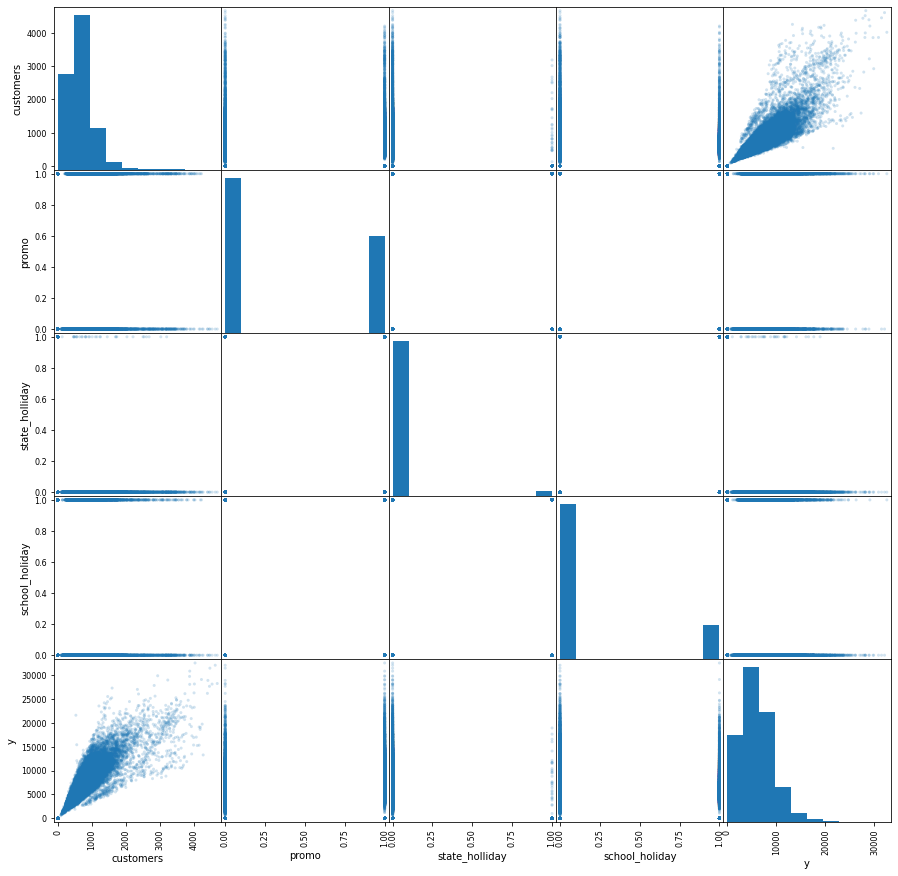

In [534]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

#Feature Eng

In [535]:
display(train_df.head())
display(store_df.head())

,id,date,customers,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,1,1,0
1,128,2013-01-01,0,0,1,1,0
2,420,2013-01-01,0,0,1,1,0
3,225,2013-01-01,0,0,1,1,0
4,144,2013-01-01,0,0,1,1,0


,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN


In [536]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [537]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [538]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

### One hot encoding

In [539]:
# Merger les jeux de données train_df et store_df selon l'id en donnant des valeurs binaires pour chaque type de magasin...

train_df_merged = train_df
test_df_merged = test_df
for col in ['store_type', 'assortment', 'promo_interval']:
    df1 = pd.get_dummies(store_df[col], prefix=col[:5])
    df1.index.names = ['id']
    df1.index += 1
    train_df_merged = pd.merge(train_df_merged,df1, how ='inner',on='id')
    test_df_merged = pd.merge(test_df_merged,df1, how ='inner',on='id')

train_df_merged


,id,date,customers,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,store_d,assor_a,assor_b,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec"
0,1042,2013-01-01,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0
1,1042,2013-01-02,548,0,0,1,3628,1,0,0,0,1,0,0,1,0,0
2,1042,2013-01-04,528,0,0,1,3627,1,0,0,0,1,0,0,1,0,0
3,1042,2013-01-05,425,0,0,0,2562,1,0,0,0,1,0,0,1,0,0
4,1042,2013-01-06,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,35,2015-07-27,828,1,0,1,13740,0,0,0,1,0,0,1,0,1,0
813763,35,2015-07-28,711,1,0,1,10877,0,0,0,1,0,0,1,0,1,0
813764,35,2015-07-29,662,1,0,1,10634,0,0,0,1,0,0,1,0,1,0
813765,35,2015-07-30,727,1,0,1,11088,0,0,0,1,0,0,1,0,1,0


In [540]:
#Supprimer la colonne Date

train_df_new = train_df_merged.drop(columns=['date'])
test_df_new = test_df_merged.drop(columns=['date'])

In [541]:
# Vérifier si train_df_new ne contient au final que des valeurs numériques

train_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                        True
customers                 True
promo                     True
state_holliday            True
school_holiday            True
y                         True
store_a                   True
store_b                   True
store_c                   True
store_d                   True
assor_a                   True
assor_b                   True
assor_c                   True
promo_Feb,May,Aug,Nov     True
promo_Jan,Apr,Jul,Oct     True
promo_Mar,Jun,Sept,Dec    True
dtype: bool

# Process and Prepare Data

In [542]:
# Separating the features and the target
X , y = train_df_new.drop(columns=['id','y']), train_df_new['y']

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}')

Input shape  : (813767, 14)
Target shape : (813767,)


In [543]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(test_df_new.drop(columns=['id','y']))

# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
print(f'Test size : {X_test.shape[0]}')

Train size : 651013
Validation size : 162754
Test size : 203442


In [544]:
X_test

array([[-1.36503015, -0.78559432,  5.64868998, ...,  2.75335745,
        -0.63623279, -0.32518483],
       [-0.50431924, -0.78559432, -0.1770322 , ...,  2.75335745,
        -0.63623279, -0.32518483],
       [-0.61864926,  1.27292163, -0.1770322 , ...,  2.75335745,
        -0.63623279, -0.32518483],
       ...,
       [ 0.9776567 , -0.78559432, -0.1770322 , ..., -0.36319294,
         1.57175174, -0.32518483],
       [ 1.17395919, -0.78559432, -0.1770322 , ..., -0.36319294,
         1.57175174, -0.32518483],
       [ 1.30770374,  1.27292163, -0.1770322 , ..., -0.36319294,
         1.57175174, -0.32518483]])

# Train Models Pipeline

In [545]:
Models = dict()

In [546]:
def train_model_grid_search(model_name, model, grid, train_data=(X_train,y_train), valid_data=(X_valid,y_valid),
                            eval_metric='neg_mean_absolute_error', save_dict=Models, verbose=1):
    """
    model_name : Name of the model
    model : sklearn model
    grid : Hyper parameters search grid
    train_data : (train inputs, train outputs)
    eval_metric : evaluation metric in the grid search
    ------------------
    Trains model on training data using a grid search and cross validation then saves trained model in save_dict
    """
    model_cv = GridSearchCV(model, grid, scoring=eval_metric, cv=5)
    model_cv.fit(X_train, y_train)
    train_preds, valid_preds = model_cv.predict(X_train) , model_cv.predict(X_valid)
    train_preds, valid_preds = np.maximum(train_preds,0) , np.maximum(valid_preds,0)
    print(train_preds)
    print(valid_preds)
    save_dict[model_name] = {'model':model_cv,
                             'scores':{'train': mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)
                                       }}
    if verbose ==1:
        print(f" -  {model_name} best hyperparameters : {model_cv.best_params_}",'\n\n')
        print(f" -  {model_name} results on the train set:" )
        print(model_cv.best_score_)
        print(f" -  {model_name} results on the valid set:")
        print(mae(y_valid, valid_preds))
        

### Linear Regression

In [547]:
train_model_grid_search(model_name = 'Linear Regression',
                        model = LinearRegression(),
                        grid = {'fit_intercept':[True,False], 
                                'copy_X':[True, False],
                                'normalize':[True,False]})

[ 4417.53053338  3794.60043389  5074.47584588 ...  7905.39233141
  6509.90795641 12003.76490838]
[8169.55397088 3704.31455374 7213.22631578 ... 7365.76100213  531.22631578
    0.        ]
 -  Linear Regression best hyperparameters : {'copy_X': True, 'fit_intercept': True, 'normalize': False} 


 -  Linear Regression results on the train set:
-896.6577026368307
 -  Linear Regression results on the valid set:
888.1249413123506


### Decision trees


In [548]:
train_model_grid_search(model_name = 'Decision Tree Regression',
                        model = DecisionTreeRegressor(random_state = 42),
                        grid = {'max_depth':list(range(2,10)),'min_samples_leaf':range(1,5)
                                })

[ 5045.84741288  4102.68960739  5481.46382501 ...  8140.60203046
  6861.74175824 12578.8266059 ]
[8449.29630117 3846.14790698 7638.83363256 ... 7865.08099008    0.
    0.        ]
 -  Decision Tree Regression best hyperparameters : {'max_depth': 9, 'min_samples_leaf': 4} 


 -  Decision Tree Regression results on the train set:
-746.4837954949894
 -  Decision Tree Regression results on the valid set:
749.2393130426461


### Random Forest

In [ ]:
train_model_grid_search(model_name = 'Random Forest Regression',
                        model = RandomForestRegressor(min_samples_split=2, random_state = 42), grid = {}
                        #grid = {'max_depth': range(10,100,50),
                        #        'min_samples_leaf':range(2,8,3),
                        #        'n_estimators': [100, 200]}
                        )

### K-NN

In [ ]:
train_model_grid_search(model_name = 'K-NN',
                        model = KNeighborsRegressor(),
                        grid = {'n_neighbors':range(1,7),
                                'weights':['uniform','distance'],
                                })

### XGBoost

In [ ]:
train_model_grid_search(model_name = 'XGBoost',
                        model = XGBRegressor(),
                        grid = {'max_depth': [3, 4, 5]})

### SVM

In [ ]:
train_model_grid_search(model_name = 'SVM',
                        model = SVR(),
                        grid = {#'C':[0.01, 1, 10],
#                                 'gamma':[0.001, 0.01, 0.1, 1],
                                'kernel':['linear']})

### Neural Network

# Approch Results

In [ ]:
df_results_1 = pd.DataFrame([[model['scores']['train'],model['scores']['valid']] for model_name,model in Models.items()],
                           columns=['train', 'validation'],
                           index=list(Models.keys()))

df_results_1.plot.bar(rot=0, figsize=(20,10))

## BEST MODEL - trained on both train and valid set

## Save as .csv